In [284]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os, pickle
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
import tensorflow as tf
from tensorflow.keras import Model ,models, layers, optimizers
from tensorflow.keras import callbacks
from sklearn import metrics

## Data Import & Preprocess

In [2]:
oz_data = open('./data/onehr.data','r')
oz_data = oz_data.readlines()

In [3]:
# to dataframe
cols = [i for i in range(0, len(oz_data[0].split(',')))]
oz_df = pd.DataFrame(columns=cols)
for cnt, rows in enumerate(oz_data):
    row = rows.split(',')
    oz_df.loc[cnt] = row
    
oz_df = oz_df.rename(columns={0:'date', 73:'target'})
oz_df['target'] = oz_df['target'].apply(lambda x: x.split('.')[0])

In [4]:
oz_df = oz_df.set_index('date')
oz_df

,1,2,3,4,5,6,7,8,9,10,...,64,65,66,67,68,69,70,71,72,target
date,,,,,,,,,,,,,,,,,,,,,
1/1/1998,0.8,1.8,2.4,2.1,2,2.1,1.5,1.7,1.9,2.3,...,0.15,10.67,-1.56,5795,-12.1,17.9,10330,-55,0,0
1/2/1998,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,...,0.48,8.39,3.84,5805,14.05,29,10275,-55,0,0
1/3/1998,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,...,0.6,6.94,9.8,5790,17.9,41.3,10235,-40,0,0
1/4/1998,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,...,0.49,8.73,10.54,5775,31.15,51.7,10195,-40,2.08,0
1/5/1998,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,1.4,...,?,?,?,?,?,?,?,?,0.58,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/27/2004,0.3,0.4,0.5,0.5,0.2,0.3,0.4,0.4,1.3,2.2,...,0.07,7.93,-4.41,5800,-25.6,21.8,10295,65,0,0
12/28/2004,1,1.4,1.1,1.7,1.5,1.7,1.8,1.5,2.1,2.4,...,0.04,5.95,-1.14,5845,-19.4,19.1,10310,15,0,0
12/29/2004,0.8,0.8,1.2,0.9,0.4,0.6,0.8,1.1,1.5,1.5,...,0.06,7.8,-0.64,5845,-9.6,35.2,10275,-35,0,0


In [5]:
# ? >> np.nan
for cols in oz_df.columns:
    oz_df[cols] = oz_df[cols].replace({'?':np.nan})
    
# null check
oz_df.isnull().sum() / len(oz_df)

1         0.117902
2         0.115142
3         0.115931
4         0.115142
5         0.115536
            ...   
69        0.049290
70        0.037461
71        0.062697
72        0.000789
target    0.000000
Length: 73, dtype: float64

In [6]:
for i in oz_df.columns:
    oz_df[i] = oz_df[i].apply(lambda x: float(x))

# fill NaN
oz_df = oz_df.fillna(method='ffill')
oz_df = oz_df.fillna(method='bfill')
oz_df

,1,2,3,4,5,6,7,8,9,10,...,64,65,66,67,68,69,70,71,72,target
date,,,,,,,,,,,,,,,,,,,,,
1/1/1998,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,2.3,...,0.15,10.67,-1.56,5795.0,-12.10,17.90,10330.0,-55.0,0.00,0.0
1/2/1998,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,...,0.48,8.39,3.84,5805.0,14.05,29.00,10275.0,-55.0,0.00,0.0
1/3/1998,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,...,0.60,6.94,9.80,5790.0,17.90,41.30,10235.0,-40.0,0.00,0.0
1/4/1998,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,...,0.49,8.73,10.54,5775.0,31.15,51.70,10195.0,-40.0,2.08,0.0
1/5/1998,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,1.4,...,0.49,8.73,10.54,5775.0,31.15,51.70,10195.0,-40.0,0.58,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/27/2004,0.3,0.4,0.5,0.5,0.2,0.3,0.4,0.4,1.3,2.2,...,0.07,7.93,-4.41,5800.0,-25.60,21.80,10295.0,65.0,0.00,0.0
12/28/2004,1.0,1.4,1.1,1.7,1.5,1.7,1.8,1.5,2.1,2.4,...,0.04,5.95,-1.14,5845.0,-19.40,19.10,10310.0,15.0,0.00,0.0
12/29/2004,0.8,0.8,1.2,0.9,0.4,0.6,0.8,1.1,1.5,1.5,...,0.06,7.80,-0.64,5845.0,-9.60,35.20,10275.0,-35.0,0.00,0.0


In [7]:
Counter(oz_df['target'])

Counter({0.0: 2463, 1.0: 73})

## Train & Test split

In [276]:
# train & test split
train = oz_df.loc['1/1/1998':'1/1/2002'].drop('target', axis=1)
test = oz_df.loc['1/1/2002':].drop('target', axis=1)

y_train = oz_df.loc['1/1/1998':'1/1/2002']['target']
y_test = oz_df.loc['1/1/2002':]['target']

## Scale(z-score)

In [277]:
# scale
scaled_train = (train - train.mean()) / train.std()
scaled_test = (test - train.mean()) / train.std()

print('Train Shape: ',scaled_train.shape)
print('Test Shape: ',scaled_test.shape)

Train Shape:  (1451, 72)
Test Shape:  (1086, 72)


## 1. Classification model

### 1.1 Random Forest

In [278]:
rf_params = {
    'n_estimators': [10,50,100],
    'max_depth': [i for i in range(4,13,2)],
    'min_samples_leaf': [1,2,3,4],
    'max_leaf_nodes': [i for i in range(2,6,1)]
}
rf_clf = RandomForestClassifier(class_weight='balanced')
rf_grid = GridSearchCV(estimator=rf_clf, param_grid=rf_params, cv=3, 
                       scoring='recall', n_jobs=-1, verbose=1)

rf_grid.fit(scaled_train, y_train)
print(rf_grid.best_estimator_)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    6.2s


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=2, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   13.9s finished


In [279]:
pred_train = rf_grid.predict(scaled_train)
print('Train Acc: ', rf_grid.score(scaled_train, y_train))
print('Train Recall: ', metrics.recall_score(y_train, pred_train))

pred_test = rf_grid.predict(scaled_test)
print('Test Acc: ', rf_grid.score(scaled_test, y_test))
print('Test Recall: ',metrics.recall_score(y_test, pred_test))

Train Acc:  0.9016393442622951
Train Recall:  0.11066398390342053
Test Acc:  0.75
Test Recall:  0.75


              precision    recall  f1-score   support

         0.0       1.00      0.75      0.85      1074
         1.0       0.03      0.75      0.06        12

    accuracy                           0.75      1086
   macro avg       0.51      0.75      0.46      1086
weighted avg       0.99      0.75      0.85      1086



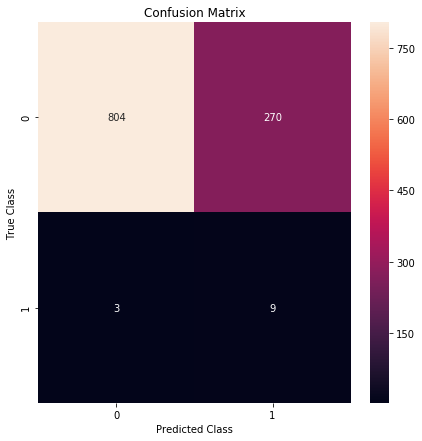

In [280]:
print(metrics.classification_report(y_test, pred_test))

conf_matrix = metrics.confusion_matrix(y_test, pred_test)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, xticklabels=[0, 1], yticklabels=[0, 1], annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class'); plt.ylabel('True Class')
plt.show()

### 2.2 Extra Trees

In [281]:
ext_params = {
    'n_estimators': [10,50,100],
    'max_depth': [i for i in range(4,13,2)],
    'min_samples_leaf': [1,2,3,4],
    'max_leaf_nodes': [i for i in range(2,6,1)]
}
ext_clf = ExtraTreesClassifier(class_weight='balanced')
ext_grid = GridSearchCV(estimator=ext_clf, param_grid=ext_params, cv=3,
                       scoring='recall', n_jobs=-1, verbose=1)

ext_grid.fit(scaled_train, y_train)
print(ext_grid.best_estimator_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    4.4s


ExtraTreesClassifier(bootstrap=False, class_weight='balanced', criterion='gini',
                     max_depth=12, max_features='auto', max_leaf_nodes=2,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    9.7s finished


In [282]:
pred_train = ext_grid.predict(scaled_train)
print('Train Acc: ', ext_grid.score(scaled_train, y_train))
print('Train Recall: ', metrics.recall_score(y_train, pred_train))

pred_test = ext_grid.predict(scaled_test)
print('Test Acc: ', ext_grid.score(scaled_test, y_test))
print('Test Recall: ',metrics.recall_score(y_test, pred_test))

Train Acc:  0.9344262295081968
Train Recall:  0.0967741935483871
Test Acc:  0.8333333333333334
Test Recall:  0.8333333333333334


              precision    recall  f1-score   support

         0.0       1.00      0.66      0.79      1074
         1.0       0.03      0.83      0.05        12

    accuracy                           0.66      1086
   macro avg       0.51      0.75      0.42      1086
weighted avg       0.99      0.66      0.78      1086



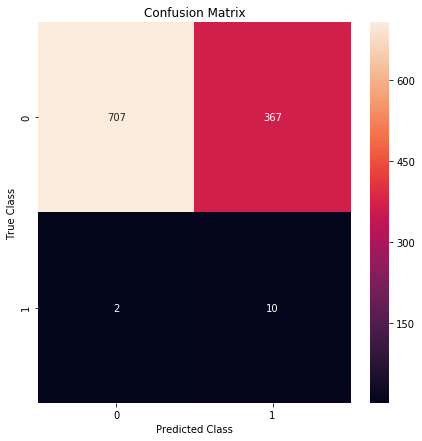

In [283]:
print(metrics.classification_report(y_test, pred_test))

conf_matrix = metrics.confusion_matrix(y_test, pred_test)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, xticklabels=[0, 1], yticklabels=[0, 1], annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class'); plt.ylabel('True Class')
plt.show()

In [286]:
# save model 
ext_grid_pickle = pickle.dumps(ext_grid)

joblib.dump(ext_grid, './model_t50/ExtraTreesGrid.pkl')

['./model_t50/ExtraTreesGrid.pkl']

## 2. LSTM Autoencoder for create future value

In [16]:
'''
reshape [samples, timesteps, features]
[len(data.shape[0], 5, len(data.shape[1])]
1-6    6-11    11-16
2-7    7-12    12-17
3-8    8-13    13-18
4-9    9-14    14-19
5-10  10-15    15-20
'''
def getSeriesData_ae(data, timesteps):
    n_pairs = len(data) - timesteps
    ec_seqences = [data[i : i+timesteps] for i in range(0, n_pairs, timesteps)]
    dc_seqences = [data[i+timesteps : i+(timesteps*2)] for i in range(0, n_pairs-timesteps, timesteps)]
    
    return np.array(ec_seqences), np.array(dc_seqences)

In [17]:
timesteps = 5
input_dim = scaled_train.shape[1]

train_ec, train_dc = getSeriesData_ae(scaled_train.values, timesteps)
test_ec, test_dc = getSeriesData_ae(scaled_test.values, timesteps)

In [18]:
train_ec = train_ec[:-1] # train_dc 길이를 맞춰주기 위해 마지막 시퀀스 제거 
print(train_ec.shape)
print(train_dc.shape)

test_ec = test_ec[:-1] # test_dc 길이를 맞춰주기 위해 마지막 시퀀스 제거 
print(test_ec.shape)
print(test_dc.shape)

(433, 5, 72)
(433, 5, 72)
(72, 5, 72)
(72, 5, 72)


In [19]:
# define model 
input_layer = layers.Input(shape=(timesteps, input_dim))
encoder = layers.LSTM(30, activation='relu')(input_layer)
decoder = layers.RepeatVector(timesteps)(encoder)
decoder = layers.LSTM(30, activation='relu', return_sequences=True)(decoder)
decoder = layers.TimeDistributed(layers.Dense(input_dim))(decoder)

model = Model(inputs=input_layer, outputs=decoder)

# compile
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5, 72)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                12360     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 30)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 30)             7320      
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 72)             2232      
Total params: 21,912
Trainable params: 21,912
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
# fit model
epochs = 500
history = model.fit(train_ec, train_dc, epochs=epochs, verbose=1)

Train on 433 samples
Epoch 1/500
433/433 [==============================] - 2s 4ms/sample - loss: 0.9822 - mse: 0.9822
Epoch 2/500
433/433 [==============================] - 0s 364us/sample - loss: 0.9238 - mse: 0.9238
Epoch 3/500
433/433 [==============================] - 0s 362us/sample - loss: 0.8552 - mse: 0.8552
Epoch 4/500
433/433 [==============================] - 0s 364us/sample - loss: 0.7903 - mse: 0.7903
Epoch 5/500
433/433 [==============================] - 0s 369us/sample - loss: 0.7389 - mse: 0.7389
Epoch 6/500
433/433 [==============================] - 0s 359us/sample - loss: 0.7057 - mse: 0.7057
Epoch 7/500
433/433 [==============================] - 0s 369us/sample - loss: 0.6820 - mse: 0.6820
Epoch 8/500
433/433 [==============================] - 0s 362us/sample - loss: 0.6681 - mse: 0.6681
Epoch 9/500
433/433 [==============================] - 0s 368us/sample - loss: 0.6573 - mse: 0.6573
Epoch 10/500
433/433 [==============================] - 0s 364us/sample - loss: 0

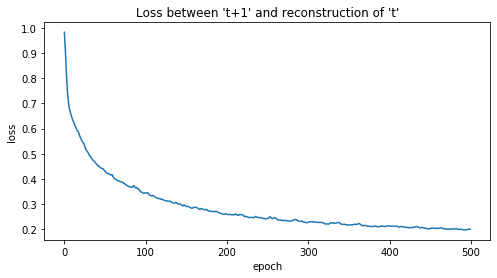

In [21]:
loss = history.history['loss']
plt.figure(figsize=(8,4))
plt.plot(range(0, epochs), loss, label='Loss')
plt.title("Loss between 't+1' and reconstruction of 't'")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [22]:
# test score
loss, mse = model.evaluate(test_ec, test_dc)
print('mse of test: ',mse)

72/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [23]:
# reconstruction
pred = model.predict(test_ec)

# future value
future_value = pred[-1:]

In [289]:
future_value

array([[[ 5.06242633e-01,  7.04212308e-01,  6.05242312e-01,
          7.09652722e-01,  8.11226547e-01,  8.13420713e-01,
          7.24370658e-01,  7.34983146e-01,  7.15959728e-01,
          5.89542985e-01,  2.01928034e-01, -6.98067248e-03,
         -6.02119714e-02, -2.62317598e-01, -4.84356463e-01,
         -7.66965985e-01, -8.77079189e-01, -9.23557997e-01,
         -6.00969493e-01, -7.42234066e-02,  9.80935469e-02,
          3.27369869e-01,  3.38637620e-01,  3.94332826e-01,
         -7.49366522e-01,  7.99524039e-02, -2.73510265e+00,
         -2.73084664e+00, -2.75348926e+00, -2.75083852e+00,
         -2.74679112e+00, -2.74232721e+00, -2.72891450e+00,
         -2.70686221e+00, -2.75673938e+00, -2.81607866e+00,
         -2.84183264e+00, -2.85083723e+00, -2.83140516e+00,
         -2.78511214e+00, -2.75357008e+00, -2.73249245e+00,
         -2.69749403e+00, -2.63776779e+00, -2.55096817e+00,
         -2.46145749e+00, -2.37710047e+00, -2.28212190e+00,
         -2.20313430e+00, -2.10415721e+0

In [30]:
future_value[:,1,:]

array([[-0.1577229 ,  0.02620538, -0.05152671, -0.15756662, -0.35032016,
        -0.45398715, -0.5014654 , -0.3875026 , -0.32999164, -0.07790376,
        -0.14448117, -0.1828921 ,  0.01767229, -0.00330879,  0.21958905,
         0.4479036 ,  0.3361913 ,  0.17638585, -0.18857644,  0.03072875,
         0.11323199,  0.04181445, -0.14669576, -0.26502115, -0.2565215 ,
         0.07799213, -2.0748687 , -2.0836065 , -2.0982013 , -2.1026914 ,
        -2.1029232 , -2.0942833 , -2.0503287 , -1.9394214 , -1.8372238 ,
        -1.6893283 , -1.5758018 , -1.452657  , -1.3178937 , -1.246531  ,
        -1.1775668 , -1.1076485 , -1.1509372 , -1.2301333 , -1.3270164 ,
        -1.3810073 , -1.4216155 , -1.4530296 , -1.4767656 , -1.4727998 ,
        -1.398239  , -1.6890119 , -1.2431829 , -1.58837   ,  1.5756973 ,
        -0.7119633 ,  1.0816792 , -0.68059427, -1.2091043 ,  1.6653906 ,
        -0.8452627 ,  0.23941854, -0.6131311 , -0.87190443,  1.7282889 ,
        -0.8369897 , -0.14252526, -1.7768618 , -1.9

## 3. Apply future value to clf model

In [287]:
# Load clf model
ext_grid = joblib.load('./model_t50/ExtraTreesGrid.pkl')

In [297]:
# reshape 3d to 2d
future_value_2d = future_value.reshape(future_value.shape[1], future_value.shape[2])
future_value_2d[0]

array([ 0.50624263,  0.7042123 ,  0.6052423 ,  0.7096527 ,  0.81122655,
        0.8134207 ,  0.72437066,  0.73498315,  0.7159597 ,  0.589543  ,
        0.20192803, -0.00698067, -0.06021197, -0.2623176 , -0.48435646,
       -0.766966  , -0.8770792 , -0.923558  , -0.6009695 , -0.07422341,
        0.09809355,  0.32736987,  0.33863762,  0.39433283, -0.7493665 ,
        0.0799524 , -2.7351027 , -2.7308466 , -2.7534893 , -2.7508385 ,
       -2.7467911 , -2.7423272 , -2.7289145 , -2.7068622 , -2.7567394 ,
       -2.8160787 , -2.8418326 , -2.8508372 , -2.8314052 , -2.7851121 ,
       -2.75357   , -2.7324924 , -2.697494  , -2.6377678 , -2.5509682 ,
       -2.4614575 , -2.3771005 , -2.282122  , -2.2031343 , -2.1041572 ,
       -2.830089  , -2.766547  , -1.5174654 , -1.2457684 ,  1.0128323 ,
       -1.2126629 ,  0.6112026 , -1.4055864 ,  0.69214314,  1.7301879 ,
       -0.5145969 , -0.28161559, -0.95238805,  1.2274542 ,  1.7814603 ,
       -0.21255562, -0.7084541 , -0.7171439 , -1.7174919 ,  2.38

In [306]:
# Predict
pred_list = []
for row in future_value_2d:
    row = row.reshape(1,-1)
    pred_list.append(int(ext_grid.predict(row)))

In [307]:
print(pred_list)

[array([0.]), array([0.]), array([0.]), array([0.]), array([0.])]